In [53]:
# %load_ext cudf.pandas
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score # To calculate quadratic weighted Kappa
from sklearn.pipeline import Pipeline


from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import clone, BaseEstimator, RegressorMixin

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

In [127]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
data_dictionary = pd.read_csv('data_dictionary.csv')

# For the Kaggle notebook
# train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
# test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
# data_dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')


# TODO: delete this
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df = train_df.copy()


In [128]:
train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


# Exploratory Data Analysis

### Severity Impairment Index
First, we'll look at the distribution of `sii` data

In [129]:
sii_data = train_df['sii'].value_counts().reset_index()
sii_data.columns = ['sii_label', 'count']
sii_data['percent_of_total'] = round((sii_data['count'] / len(train_df)) * 100,1)
sii_data
print(f"{sii_data}\n")
print(f"{100.0*train_df['sii'].isnull().sum()/len(train_df):.2f}% of the sii data is null")

   sii_label  count  percent_of_total
0        0.0   1594              40.3
1        1.0    730              18.4
2        2.0    378               9.5
3        3.0     34               0.9

30.91% of the sii data is null


### Demographics
Let's look through the data related to demographics

In [130]:
df['Basic_Demos-Sex'].value_counts()

Basic_Demos-Sex
0    2484
1    1476
Name: count, dtype: int64

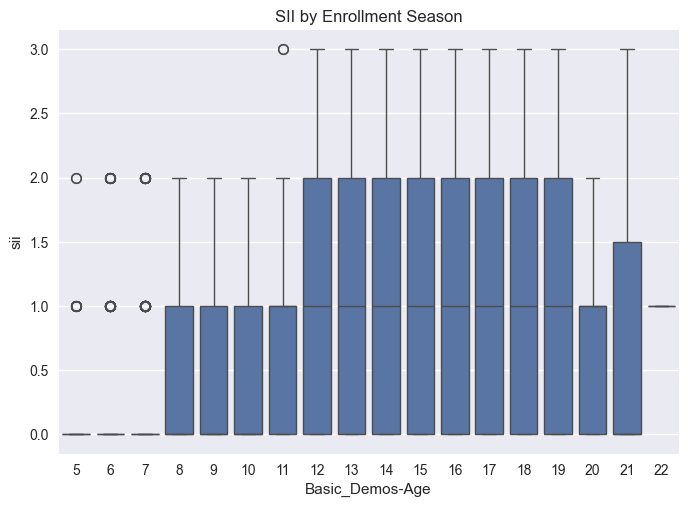

In [131]:
plt.style.use('seaborn-v0_8')
sns.boxplot(x='Basic_Demos-Age', y='sii', data=train_df)
plt.title('SII by Enrollment Season')

plt.show()

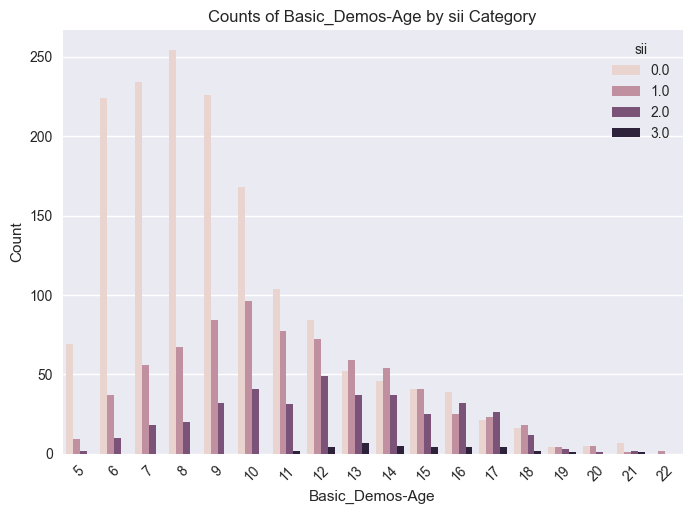

In [132]:
age_sii_counts = train_df.groupby(['Basic_Demos-Age', 'sii']).size().reset_index(name='count')
sns.barplot(data=age_sii_counts, x='Basic_Demos-Age', y='count', hue='sii')
plt.title('Counts of Basic_Demos-Age by sii Category')
plt.xlabel('Basic_Demos-Age')
plt.ylabel('Count')
plt.legend(title='sii')
plt.xticks(rotation=45)
plt.show()

Here's what we learned:
* We learned that our dataset is mostly males, about 63% male to 37% female
* Also, the interquartile range of `sii` increases with older ages. 
* Younger ages are prone to less severe impairment
* The magnitude of the severity changes based on the age in consideration. E.g.
    * 0 risk -> 8 yrs old
    * 1 risk -> 10 yrs old
    * 2 risk -> 12 yrs old
    * 3 risk -> 13 yrs old

Not shown:
* No trend between `Basic_Demos-Enroll_Season` and `sii`

### Children's Global Assessment Scale

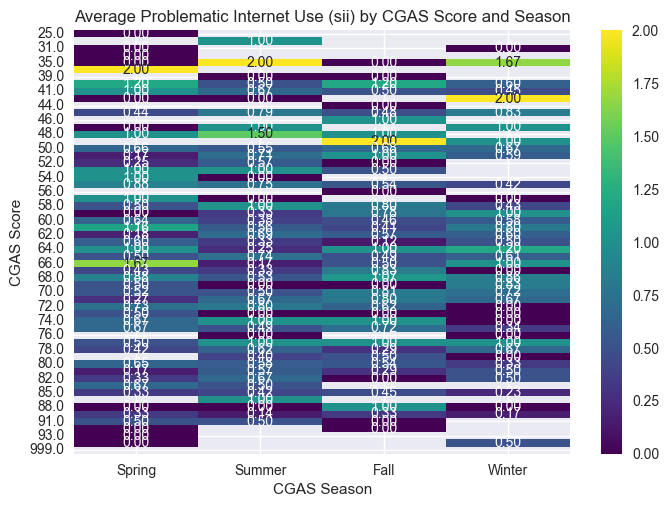

In [133]:
heatmap_data = train_df.groupby(['CGAS-CGAS_Score', 'CGAS-Season'])['sii'].mean().reset_index()
heatmap_data = heatmap_data.pivot(index='CGAS-CGAS_Score', columns='CGAS-Season', values='sii')
column_order = ["Spring", "Summer", "Fall", "Winter"]
heatmap_data = heatmap_data.reindex(columns=column_order) # want the seasons to be in chronological
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f") 
plt.title('Average Problematic Internet Use (sii) by CGAS Score and Season')
plt.xlabel('CGAS Season')
plt.ylabel('CGAS Score')
plt.show()

No notable trends seen in the Children's Global Assessment Scale. Let's move on to the next instrument

### Physical Measures

In [134]:
train_df[['Physical-Season', 'Physical-BMI','Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference','Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']].describe()

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
count,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000
mean,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074
std,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225
min,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000
25%,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000
50%,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000
75%,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000
max,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000


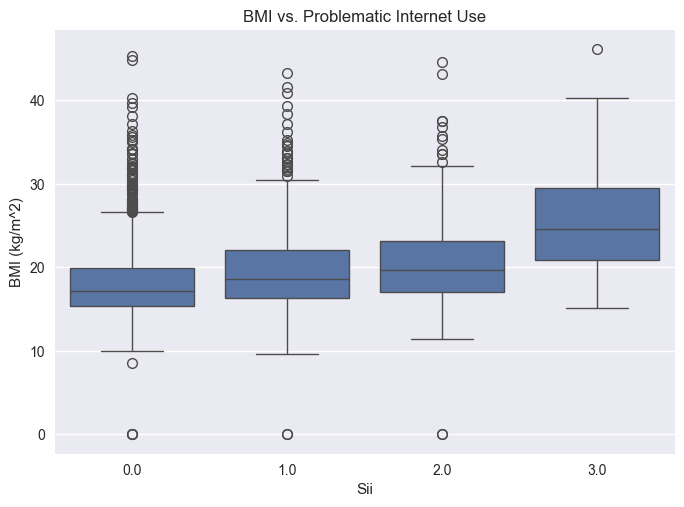

In [135]:
sns.boxplot(x='sii', y='Physical-BMI', data=train_df)
plt.title('BMI vs. Problematic Internet Use')
plt.xlabel('Sii')
plt.ylabel('BMI (kg/m^2)')
plt.show()


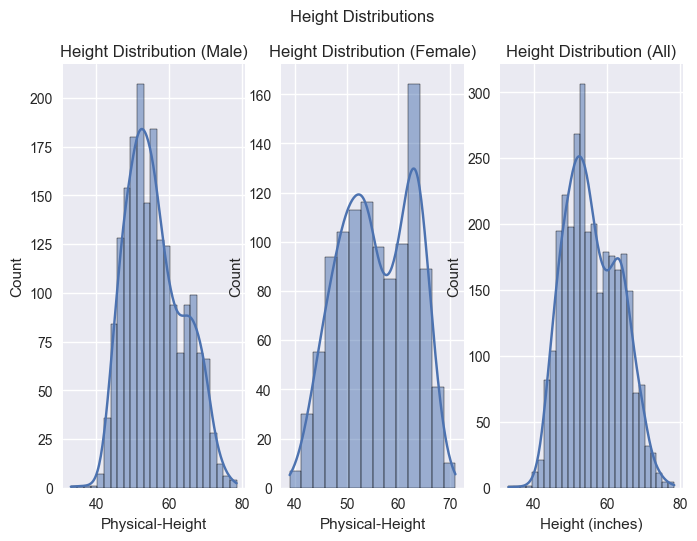

In [136]:
fig, axes = plt.subplots(1, 3)
sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 0]['Physical-Height'], kde=True, ax=axes[0])
axes[0].set_title('Height Distribution (Male)')

sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 1]['Physical-Height'], kde=True, ax=axes[1])
axes[1].set_title('Height Distribution (Female)')

sns.histplot(train_df['Physical-Height'], kde=True, ax=axes[2])
axes[2].set_title('Height Distribution (All)')

plt.suptitle('Height Distributions')
plt.xlabel('Height (inches)')
plt.show()

Here's what we learned: 
- Higher BMI corresponds to higher `sii`. The 50 percentile of BMI for "Severe" sii is higher than the 75 percentile for "Moderate" sii
- There was minimal variance in the season w.r.t. the `sii`
- The distribution of heights seemed to take on the form of a bimodal distribution instead of a typical normal distribution. This is likely because males and females are different heights, so the resulting histogram has 2 peaks. The males are the shorter peak because they are typically shorter in the age range collected in this dataset.

### FitnessGram Vitals and Treadmill

In [137]:
list(train_df.filter(like='Fitness_Endurance').columns)

['Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec']

In [138]:
train_df[['Fitness_Endurance-Max_Stage','Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec','sii']].corr()

,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,sii
Fitness_Endurance-Max_Stage,1.000000,0.873138,-0.138393,-0.070589
Fitness_Endurance-Time_Mins,0.873138,1.000000,-0.201425,-0.060628
Fitness_Endurance-Time_Sec,-0.138393,-0.201425,1.000000,0.008701
sii,-0.070589,-0.060628,0.008701,1.000000


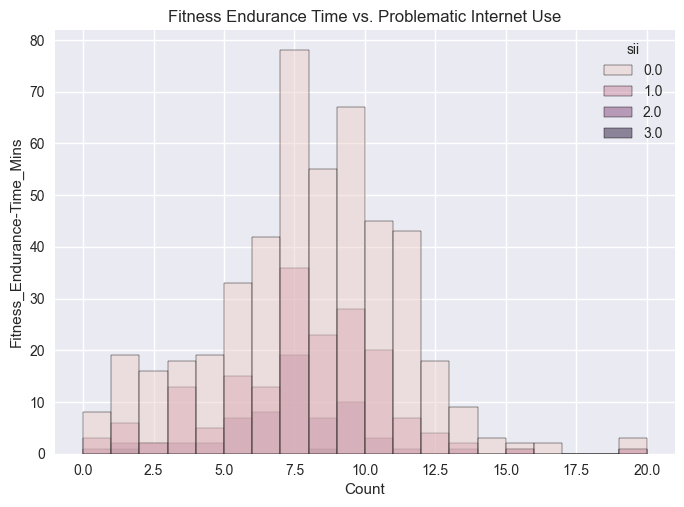

In [139]:
sns.histplot(train_df, x='Fitness_Endurance-Time_Mins',bins=20, hue='sii')
plt.title('Fitness Endurance Time vs. Problematic Internet Use')
plt.xlabel('Count')
plt.ylabel('Fitness_Endurance-Time_Mins')
plt.show()


Here's what we learned:
- `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec` should be combined into 1 column. This will be done later
- There wasnt a strong correlation with any of these columns and `sii`

### FitnessGram Child

In [140]:
fgc_cols = list(train_df.filter(like='FGC').columns) + ['sii']
train_df[fgc_cols].describe()


,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,sii
count,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,2736.000000
mean,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,0.580409
std,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,0.771122
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,15.100000,1.000000,16.200000,2.000000,0.000000,0.000000,7.000000,0.000000,7.000000,0.000000,7.000000,1.000000,0.000000
50%,9.000000,0.000000,20.050000,2.000000,21.200000,2.000000,3.000000,0.000000,9.000000,1.000000,9.000000,1.000000,10.000000,1.000000,0.000000
75%,15.750000,1.000000,26.600000,2.000000,28.175000,2.000000,9.000000,1.000000,11.000000,1.000000,11.000000,1.000000,12.000000,1.000000,1.000000
max,115.000000,1.000000,124.000000,3.000000,123.800000,3.000000,51.000000,1.000000,21.700000,1.000000,21.000000,1.000000,22.000000,1.000000,3.000000


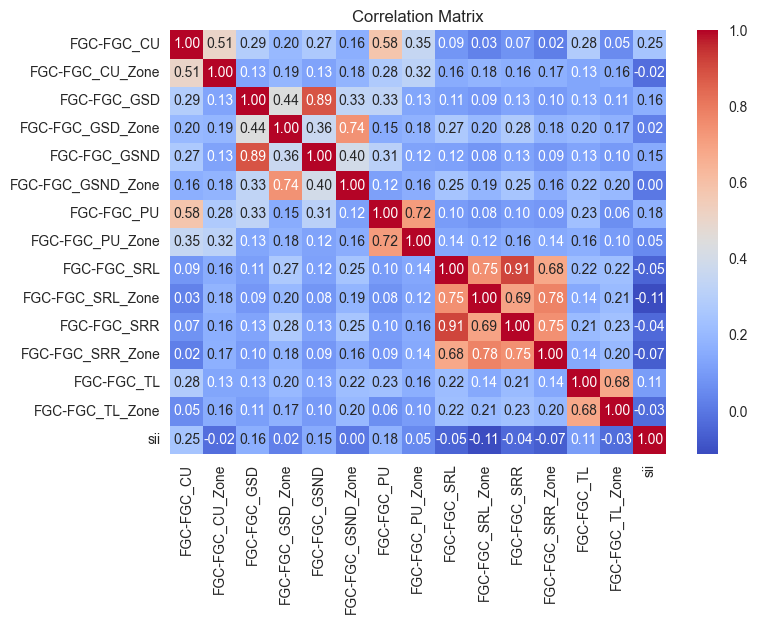

In [141]:
corr_matrix = train_df[fgc_cols].drop(columns=['FGC-Season']).corr()
sorted_cols = corr_matrix.columns.sort_values()
sorted_corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]

sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Here's what we learned:
- Interestingly, there isn't as high of a correlation between the raw values and the categorized "zones". 
    - The highest observed correlation between a category and its zone was only 0.75 for `FGC_FGC_SRR` and `FGC_FGC_SRL`. (These two measurements are just the left and right legs of the Sit & Reach.)

### Bio-electric Impedance Analysis

In [142]:
bia_cols = list(train_df.filter(like='BIA-').columns) + ['sii']
train_df[bia_cols].describe()

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,sii
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,2736.000000
mean,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,0.580409
std,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.771122
min,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.000000
25%,2.000000,2.966905,15.913600,1004.710000,1605.785000,11.109550,49.278100,13.408000,2.306915,8.602395,1.000000,24.463500,12.98315,45.204100,21.141550,35.887000,0.000000
50%,3.000000,3.922720,17.966500,1115.380000,1863.980000,15.928000,61.066200,14.092500,3.698630,16.174600,2.000000,28.855800,16.43880,56.996400,27.415100,44.987000,0.000000
75%,3.000000,5.460925,21.461100,1310.360000,2218.145000,25.162200,81.833800,15.430950,5.987690,30.273100,2.000000,35.475700,22.16760,77.105650,38.179400,60.271050,1.000000
max,5.000000,4115.360000,53.924300,83152.200000,124728.000000,3233.000000,8799.080000,217.771000,28.251500,153.820000,3.000000,2457.910000,3108.17000,4683.710000,3607.690000,5690.910000,3.000000


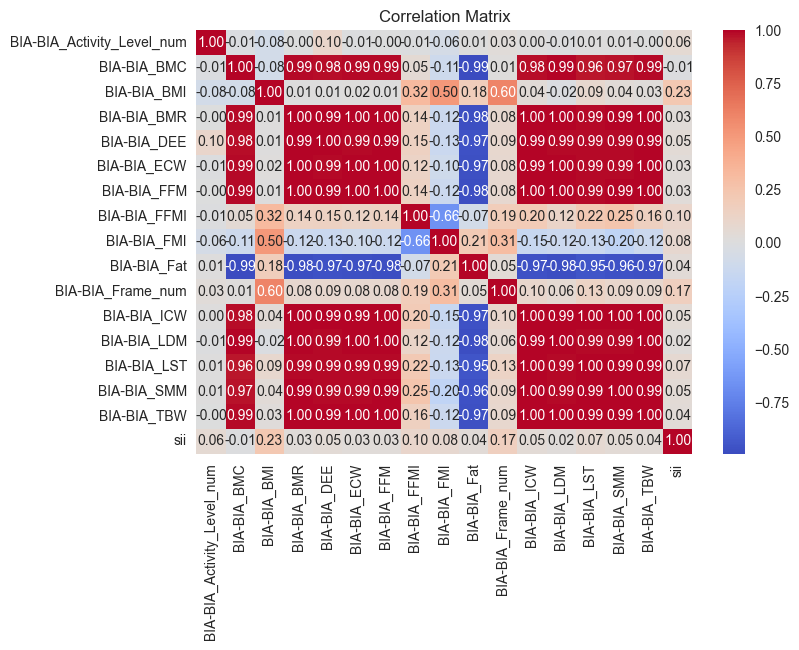

In [143]:
bia_corr_matrix = train_df[bia_cols].drop(columns=['BIA-Season']).corr()
bia_sorted_cols = bia_corr_matrix.columns.sort_values()
bia_sorted_corr_matrix = bia_corr_matrix.loc[bia_sorted_cols, bia_sorted_cols]

sns.heatmap(bia_sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Here's what we learned:
- Body Fat Percentage is inversely correlated to most BIA fields, i.e. Bone Mineral Content, Basal Metabolic Rate, Daily Energy Expenditure, Extracellular Water, Fat Free Mass, Intracellular Water, Lean Dry Mass, Lean Soft Tissue, Skeletal Muscle Mass, Total Body Water.
- Basal Metabolic Rate, Daily Energy Expenditure, Extracellular Water, and Fat Free Mass are all correlated to each other.
- Similarly, Intracellular Water, Lean Dry Mass, Lean Soft Tissue, Skeletal Muscle Mass, and Total Body Water are correlated to each other
- No one attribute correlates to `sii`

### Physical Activity Questionnaire

Text(0.5, 1.0, 'Physical Actiity Questionnaire (Children)')

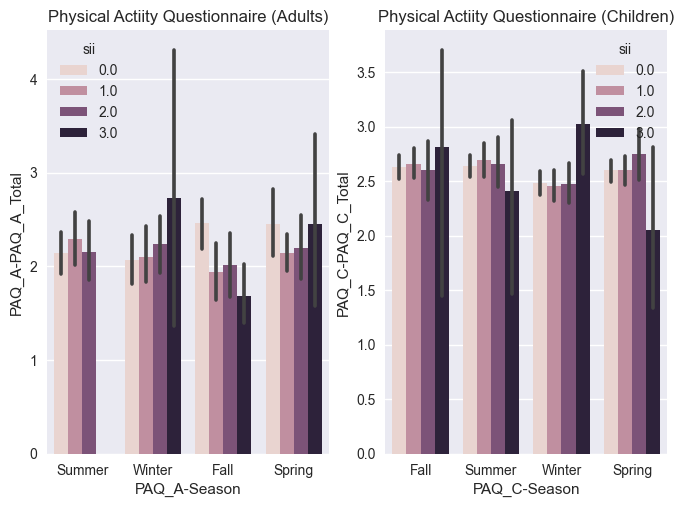

In [144]:
fig, axes = plt.subplots(1,2)
sns.barplot(data=train_df, x='PAQ_A-Season', y='PAQ_A-PAQ_A_Total', hue='sii', ax=axes[0])
axes[0].set_title('Physical Actiity Questionnaire (Adults)')

sns.barplot(data=train_df, x='PAQ_C-Season', y='PAQ_C-PAQ_C_Total', hue='sii', ax=axes[1])
axes[1].set_title('Physical Actiity Questionnaire (Children)')

Here's what we learned:
- There are no adults with a "severe" `sii` rating in the Summer.
- Winter was the season with the most "severe" `sii` ratings for children, but it was the season with the fewest "severe" `sii` ratings for adults. 

### Parent-Child Internet Addiction Test

In [145]:
pciat_aggs = train_df.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max', 'mean'])
pciat_aggs = pciat_aggs.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score', 'mean': 'Average total PCIAT Score'}
)
pciat_aggs

,Minimum PCIAT total Score,Maximum total PCIAT Score,Average total PCIAT Score
sii,,,
0.0,0.0,30.0,13.929737
1.0,31.0,49.0,38.726027
2.0,50.0,79.0,60.658730
3.0,80.0,93.0,85.911765


In [146]:
# List all columns that are of the form PCIAT-PCIAT_XX
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]

pciat_summed_total = train_df[pciat_columns].fillna(0).sum(axis=1)
is_calculated_sum_equal_to_total_column = pciat_summed_total == train_df['PCIAT-PCIAT_Total'].fillna(0)

# Check if sum of the scores equals total for all rows
is_calculated_sum_equal_to_total_column.sum() == len(train_df)


True

Here's what we learned:
- The average of the scores for each `sii` classification was around the median of the bounds of the range (e.g. n `sii` of 0 is from 0-30, and the average score was ~14)
- The sum of the PCIAT scores all align with the classification set by the Severity Impairment Index (sii).
- The number of instances where PCIAT-PCIAT_1 through PCIAT-PCIAT_20 is equal to PCIAT-PCIAT_Total is equal to the number of records in the dataset. This shows that PCIAT-PCIAT_Total is 100% is a linear transformation of other features in this dataset, so we can drop it from the dataset later

Also, note that the **test** set does not have any of the PCIAT data, and we're missing about 30% of the `sii` label in the training data. 

### Sleep Disturbance Scale

In [147]:
bia_cols = list(train_df.filter(like='SDS-').columns) + ['sii']
train_df[bia_cols].drop(columns=['sii']).isnull().sum()/train_df[['SDS-Season','SDS-SDS_Total_Raw','SDS-SDS_Total_T']].notnull().sum()

SDS-Season           0.512605
SDS-SDS_Total_Raw    0.517823
SDS-SDS_Total_T      0.519570
dtype: float64

In [148]:
train_df[['SDS-SDS_Total_Raw','SDS-SDS_Total_T']].corr()

,SDS-SDS_Total_Raw,SDS-SDS_Total_T
SDS-SDS_Total_Raw,1.000000,0.996134
SDS-SDS_Total_T,0.996134,1.000000


Here's what we learned:
- About half of the sleep data is null
- There is an extremely strong correlation between the Total Raw Score and Total T-score

### Internet Use

In [149]:
int_use = list(train_df.filter(like='PreInt_EduHx-').columns) + ['sii']
train_df[int_use].drop(columns='PreInt_EduHx-Season').corr()

,PreInt_EduHx-computerinternet_hoursday,sii
PreInt_EduHx-computerinternet_hoursday,1.000000,0.336526
sii,0.336526,1.000000


Here's what we learned:
- There is a weak correlation between Hours of Using Computer/Internet and `sii`. This is the strongest correlation we have seen so far between a raw column and `sii`.

# Series Data

In [150]:
# path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet'
path = 'series_train.parquet/id=0417c91e/part-0.parquet'

series_train = pd.read_parquet(path)
series_train

# def plot_series_data(df, col='non-wear_flag',
#                      label='Worn (0 = Worn, 1 = Not Worn)',
#                      title='Non-Wear Flag',
#                      x_col='day_time', x_label='Day Relative to PCIAT + Time'):
#     plt.figure(figsize=(18, 12))
    
#     # ENMO
#     plt.subplot(4, 1, 1)
#     plt.scatter(df[x_col], df['enmo'], label='ENMO', color='green', s=1)
#     plt.title('ENMO (Euclidean Norm Minus One)')
#     plt.ylabel('Movement Intensity')

#     # Angle Z
#     plt.subplot(4, 1, 2)
#     plt.scatter(df[x_col], df['anglez'], label='Angle Z', color='blue', s=1)
#     plt.title('Angle Z')
#     plt.ylabel('Angle (degrees)')

#     # Light
#     plt.subplot(4, 1, 3)
#     plt.scatter(df[x_col], df['light'], label='Light', color='orange', s=1)
#     plt.title('Ambient Light')
#     plt.ylabel('Light (lux)')

#     # Any other column
#     plt.subplot(4, 1, 4)
#     plt.scatter(df[x_col], df[col], label=col, color='red', s=1)
#     plt.title(f'{title}')
#     plt.ylabel(f'{label}')
#     plt.xlabel(f'{x_label}')

#     plt.tight_layout()
#     plt.show()
series_train


,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.014375,-0.020112,-0.995358,0.001060,-88.445251,0.0,41.000000,4195.000000,44100000000000,2,2,5.0
1,1,0.014167,-0.023278,-0.996164,0.000289,-88.372200,0.0,41.000000,4194.833496,44105000000000,2,2,5.0
2,2,0.014036,-0.022964,-0.996320,0.000301,-88.356422,0.0,41.500000,4194.666504,44110000000000,2,2,5.0
3,3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.500000,4194.500000,44115000000000,2,2,5.0
4,4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.000000,44780000000000,2,2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287174,287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.000000,3695.000000,32875000000000,1,3,53.0
287175,287175,-0.703572,0.016187,0.159560,0.035980,14.121390,0.0,7.000000,3695.000000,32880000000000,1,3,53.0
287176,287176,-0.209607,-0.469700,0.636573,0.097799,44.998573,0.0,7.000000,3695.000000,32885000000000,1,3,53.0
287177,287177,-0.390378,0.284386,0.147654,0.057826,7.726313,0.0,7.000000,3695.000000,32890000000000,1,3,53.0


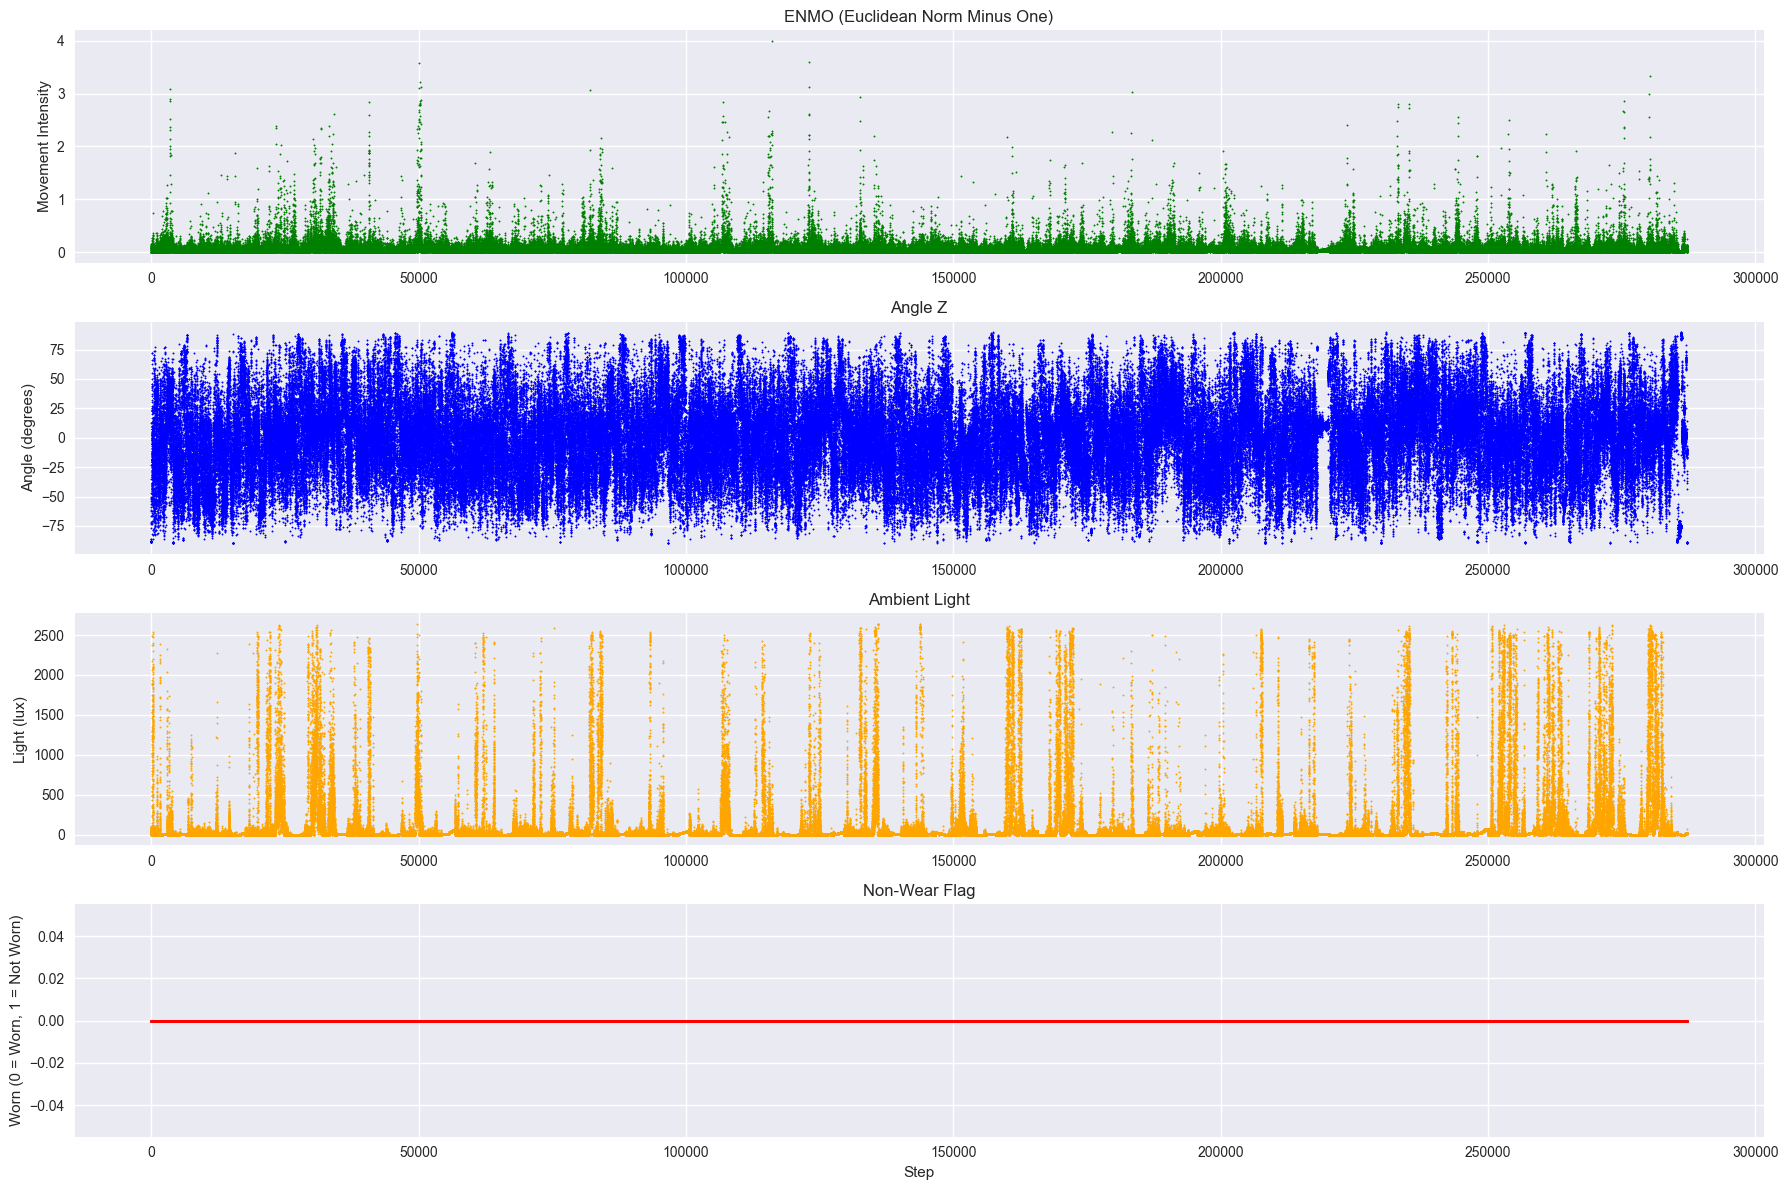

In [151]:
participant_id = path.split('/')[-2].split('=')[-1]
participant_id
train[train['id'] == participant_id]

plot_series_data(series_train, x_col='step', x_label='Step')



In [152]:
series_train['time_of_day_hours'] = series_train['time_of_day'] / 1e9 / 3600  # nanoseconds to hours
series_train['day_time'] = series_train['relative_date_PCIAT'] + series_train['time_of_day_hours'] / 24

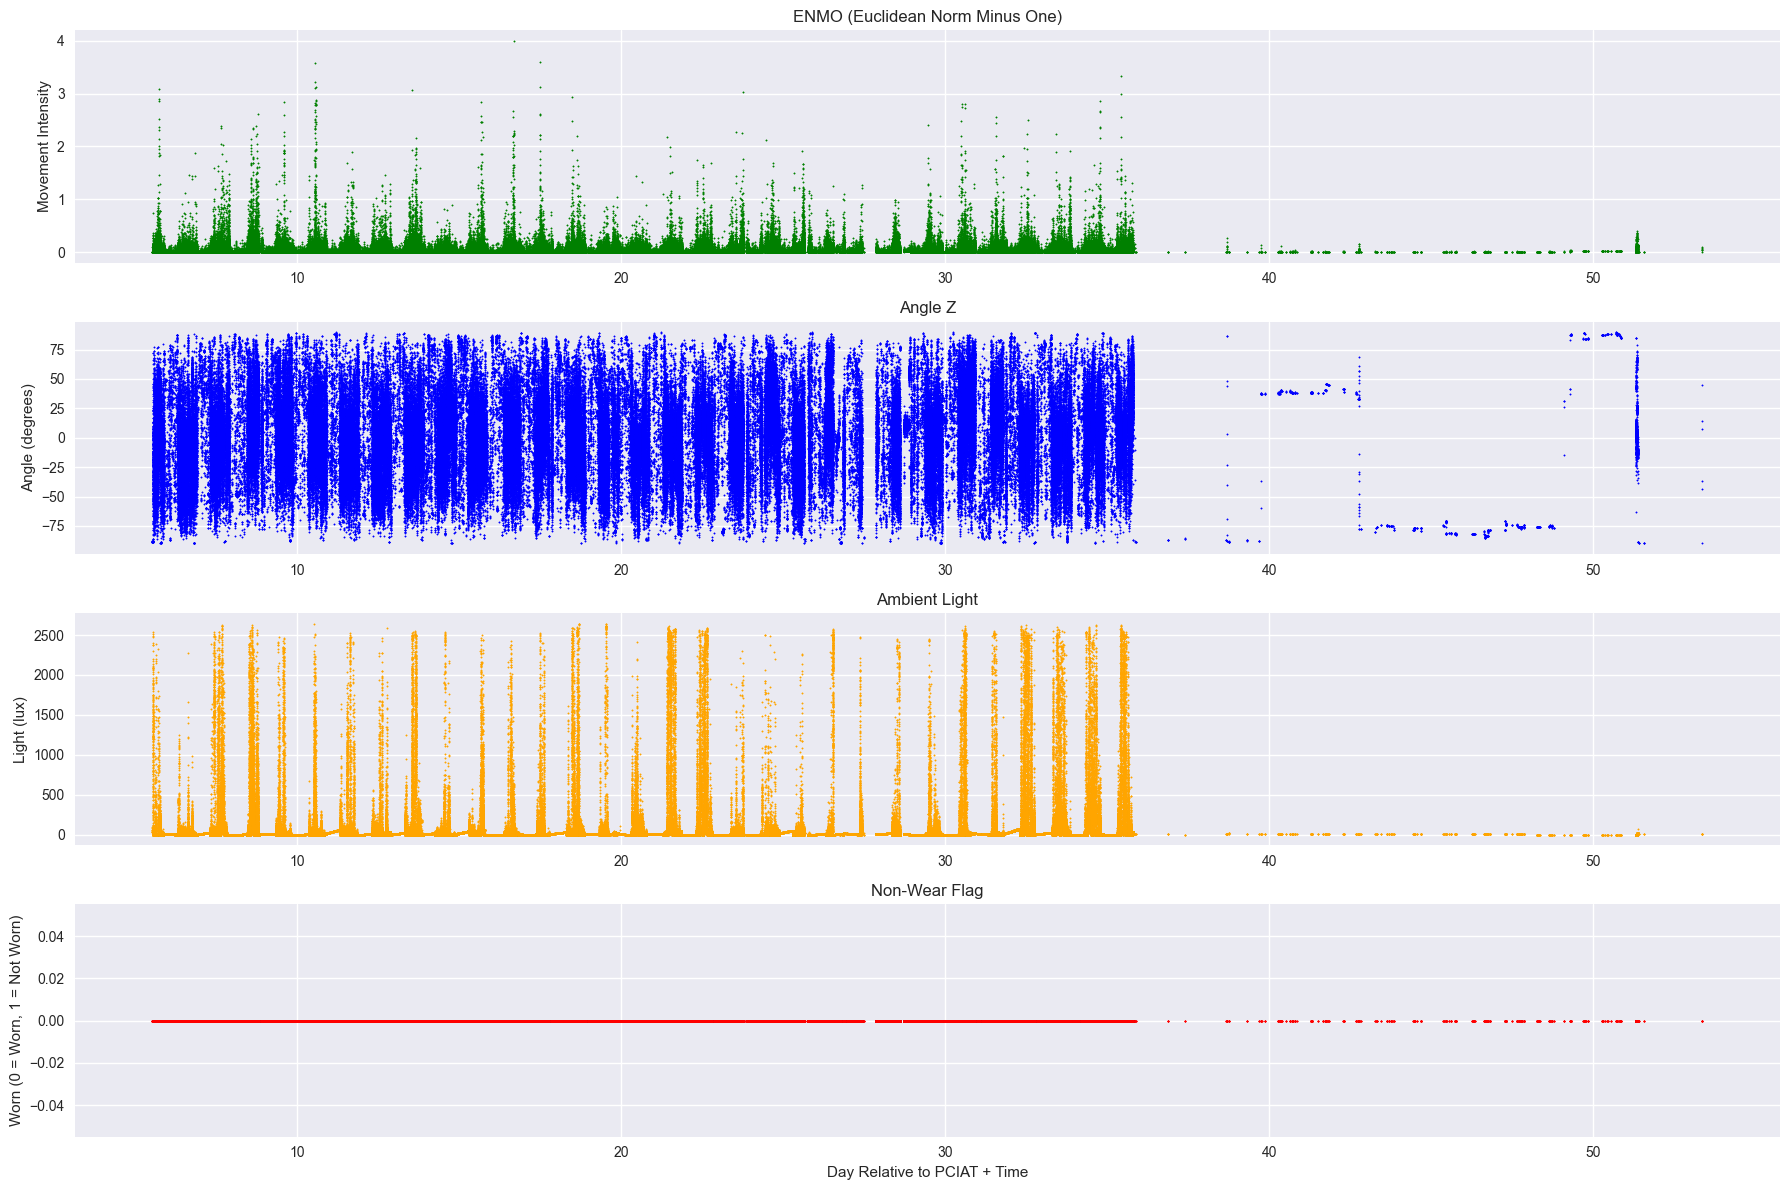

In [153]:
plot_series_data(series_train, x_col='day_time', x_label='Day Relative to PCIAT + Time')


In [154]:
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = [d for d in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, d))]
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    
    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    return data

random_raw_parquet_file = pd.read_parquet('series_train.parquet/id=0417c91e/part-0.parquet')

train_ts = load_time_series('./series_train.parquet')
test_ts = load_time_series('./series_test.parquet')
# train_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
# test_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')


100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


In [155]:
train_df = pd.merge(train_df, train_ts, how="left", on='id')
test_df = pd.merge(test_df, test_ts, how="left", on='id')

In [ ]:
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')
for col in time_series_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())
    test_df[col] = test_df[col].fillna(test_df[col].median())

In [ ]:
# TODO: Experiment with different imputation strategies (or maybe none at all)
df_corr = train_df.copy()
df_corr['sii'] = train['sii'].values.copy()

corr_sii = df_corr.corr(numeric_only=True)['sii']
corr_sii = corr_sii[(corr_sii > 0.02) | (corr_sii < -0.02)]

corr_list = corr_sii.keys().tolist()
corr_list.remove('sii')

train_df_with_correlation = train_df[corr_list].copy()
common_columns = [col for col in corr_list if col in train_df.columns and col in test_df.columns]

test_df_with_correlation = test_df[common_columns].copy()


# Data Cleaning and Basic Feature Engineering

Combine `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec` into 1 column

In [33]:
def combine_fe_time_into_one_column(df):
    # check if either column is null
    null_mask = df['Fitness_Endurance-Time_Mins'].isnull() | df['Fitness_Endurance-Time_Sec'].isnull()
    df['Fitness_Endurance-Time'] = df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'] / 60

    # set result to null if either column is null
    df.loc[null_mask, 'Fitness_Endurance-Time'] = np.nan  

    df.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'], inplace=True)

combine_fe_time_into_one_column(test_df)
combine_fe_time_into_one_column(train_df)


`SDS-SDS_Total_Raw` and `SDS-SDS_Total_T` have a 0.996 correlation. Remove the one with lesser variance.

In [34]:
print(train_df[['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']].var())

SDS-SDS_Total_Raw    108.731353
SDS-SDS_Total_T      174.136811
dtype: float64


In [35]:
def remove_sds_column(df):
    if 'SDS-SDS_Total_Raw' in df.columns:
        df.drop(['SDS-SDS_Total_Raw'], axis=1, inplace=True)
remove_sds_column(train_df)
remove_sds_column(test_df)

`PCIAT-PCIAT_Total` is the sum of all the other `PCIAT_...` columns, so we can drop it

In [36]:
def drop_pciat_columns(df):
    if 'PCIAT-PCIAT_Total' in df.columns:
        df.drop(columns='PCIAT-PCIAT_Total', inplace=True)
drop_pciat_columns(train_df)
drop_pciat_columns(test_df)

If we want to compare the variance of 2 columns, we want to make sure we're normalizing at the correct time. Things like categorical integers and percentages should not be normalized. This creates a list of columns that should not be normalized.

In [ ]:
def get_features_numeric_and_non_categorical_features_from_df(df):
    numeric_columns = df.select_dtypes(include=['int32', 'int64', 'float64']).columns
    dd_fields = data_dictionary[data_dictionary['Type'] == 'categorical int']['Field'].tolist()

    # Only normalize numeric columns that are NOT categorical int
    features = [col for col in numeric_columns if col not in dd_fields and col != 'sii']
    return features
features_to_normalize = get_features_numeric_and_non_categorical_features_from_df(train_df)

Compare the highest correlated columns in `train_df`. If 2 features have a correlation >= 0.99, drop the one with less variance.

In [38]:
def handle_highly_correlated_columns(df, threshold=0.99):
    numeric_cols = df.select_dtypes(include=['int32', 'int64', 'float64']).columns
    correlation_matrix = df[numeric_cols].corr()
    
    # Mask to avoid duplicate and self-correlations. Bascially a matrix that masks everything except the upper triangle
    upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

    # Find feature pairs with high correlation
    high_corr_pairs = [
        (correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
        for i, j in zip(*np.where((abs(correlation_matrix) > threshold) & upper_triangle))
    ]

    columns_to_drop = set()
    for col1, col2, corr_value in high_corr_pairs:
        # Normalize the columns ONLY if they are in features_to_normalize
        if col1 in features_to_normalize and col2 in features_to_normalize:
            normalized_col1 = (df[col1] - df[col1].mean()) / df[col1].std()
            normalized_col2 = (df[col2] - df[col2].mean()) / df[col2].std()

            var_col1 = normalized_col1.var()
            var_col2 = normalized_col2.var()
        else:
            var_col1 = df[col1].var()
            var_col2 = df[col2].var()

        # Drop the column with lesser normalized variance
        if var_col1 >= var_col2:
            print(f"Column {col2} has a correlation of {corr_value} with {col1}")
            columns_to_drop.add(col2)
        else:
            print(f"Column {col1} has a correlation of {corr_value} with {col2}")
            columns_to_drop.add(col1)
    return columns_to_drop

def drop_columns_from_dataframe(df, cols=[]):
    for col in cols:
        if col in df.columns:
            print(f"Dropping column {col}")
            df.drop(columns=col, inplace=True)

columns_to_drop = handle_highly_correlated_columns(train_df)

drop_columns_from_dataframe(train_df, columns_to_drop)
drop_columns_from_dataframe(test_df, columns_to_drop)


Column BIA-BIA_BMC has a correlation of -0.991533977315019 with BIA-BIA_Fat
Column BIA-BIA_BMC has a correlation of 0.9937022490642037 with BIA-BIA_LDM
Column BIA-BIA_DEE has a correlation of 0.9931077343481463 with BIA-BIA_BMR
Column BIA-BIA_BMR has a correlation of 0.9991193733794247 with BIA-BIA_ECW
Column BIA-BIA_BMR has a correlation of 0.9999999999989329 with BIA-BIA_FFM
Column BIA-BIA_BMR has a correlation of 0.9971147716051307 with BIA-BIA_ICW
Column BIA-BIA_BMR has a correlation of 0.9986669394964864 with BIA-BIA_LDM
Column BIA-BIA_LST has a correlation of 0.9921417801292591 with BIA-BIA_BMR
Column BIA-BIA_SMM has a correlation of 0.9922821810727989 with BIA-BIA_BMR
Column BIA-BIA_TBW has a correlation of 0.9996074521048101 with BIA-BIA_BMR
Column BIA-BIA_DEE has a correlation of 0.9913149986586861 with BIA-BIA_ECW
Column BIA-BIA_DEE has a correlation of 0.9931077333288205 with BIA-BIA_FFM
Column BIA-BIA_DEE has a correlation of 0.9929058844288748 with BIA-BIA_ICW
Column BIA-B

In the EDA above, there was no correlation between Season and `sii` or any other metric. Drop those columns

In [39]:
def drop_season_cols(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1, inplace=True) 
drop_season_cols(train_df)
drop_season_cols(test_df)

We should also check for outliers and replace them with `NaN`. As an example, `CGAS-CGAS_Score` has a value of 999, which is an error

In [40]:
def handle_outliers(df, column, valid_min, valid_max, placeholder_value=np.nan):
    outliers = (df[column] < valid_min) | (df[column] > valid_max)
    
    print(f"Found {outliers.sum()} outliers in column '{column}'.")
    
    df.loc[outliers, column] = placeholder_value

handle_outliers(train_df, 'CGAS-CGAS_Score', 0, 100, np.nan)
handle_outliers(test_df, 'CGAS-CGAS_Score', 0, 100, np.nan)
handle_outliers(train_df, 'SDS-SDS_Total_T', 0, 100, np.nan)
handle_outliers(test_df, 'SDS-SDS_Total_T', 0, 100, np.nan)

Found 1 outliers in column 'CGAS-CGAS_Score'.
Found 0 outliers in column 'CGAS-CGAS_Score'.
Found 0 outliers in column 'SDS-SDS_Total_T'.
Found 0 outliers in column 'SDS-SDS_Total_T'.


# Impute Missing Data

### Remove Sparse Records

There are a handful of records that are almost entirely null. We will remove these from the training data. However, every record has a value for`id`, `Basic_Demos-Age`, and `Basic_Demos-Sex`. Therefore, if a record has all remaining columns listes as `NaN`, it is safe to drop them from `train_df`. 

In [41]:
pd.set_option('display.max_rows', 10)
print(f"There are {len(train_df.columns)} columns in the training data and {len(test_df.columns)} columns in the test data.\n")
null_counts_per_row = train_df.isnull().sum(axis=1)
null_counts_distribution = null_counts_per_row.value_counts().sort_index()
print(f"Here are the number of null columns each record has:\n {null_counts_distribution}")

There are 59 columns in the training data and 38 columns in the test data.

Here are the number of null columns each record has:
 2     127
3     106
4     350
5      80
6     220
     ... 
52      6
53     16
54    101
55    220
56    364
Name: count, Length: 55, dtype: int64


In [42]:
null_counts_per_row = train_df.isnull().sum(axis=1)
non_null_columns = len(train_df.columns) - 3
df_with_max_nulls = train_df[null_counts_per_row == non_null_columns]
# df_with_max_nulls

In [43]:
threshold = 0.1  # require at least 10% of the dataset be non-null
row_threshold = int(threshold * train_df.shape[1])
train_df.dropna(thresh=row_threshold, axis=0, inplace=True)

In [44]:
pd.set_option('display.max_rows', 10)
print(f"There are {len(train_df.columns)} columns in the training data and {len(test_df.columns)} columns in the test data.\n")
null_counts_per_row = train_df.isnull().sum(axis=1)
null_counts_distribution = null_counts_per_row.value_counts().sort_index()
print(f"Here are the number of null columns each record has:\n {null_counts_distribution}")

There are 59 columns in the training data and 38 columns in the test data.

Here are the number of null columns each record has:
 2     127
3     106
4     350
5      80
6     220
     ... 
50      3
51      2
52      6
53     16
54    101
Name: count, Length: 53, dtype: int64


### Use k-NN to Impute Missing Numeric, Non-categorical Data

In [45]:
def knn_impute(df, n_neighbors=5):
    features_to_impute = get_features_numeric_and_non_categorical_features_from_df(train_df)
    
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform k-NN imputation and ensure the result integrates with the DataFrame
    imputed_data = imputer.fit_transform(df[features_to_impute])
    df[features_to_impute] = pd.DataFrame(imputed_data, columns=features_to_impute, index=df.index)
    
    return df

train_df = knn_impute(train_df, n_neighbors=5)
test_df = knn_impute(test_df, n_neighbors=5)


### Use k-NN to Impute Missing Numeric, Categorical Data

In [46]:
# Basic_Demos-Sex was removed from this list
numeric_categorical_data = ['FGC-FGC_CU_Zone','FGC-FGC_GSND_Zone','FGC-FGC_GSD_Zone','FGC-FGC_PU_Zone','FGC-FGC_SRL_Zone','FGC-FGC_SRR_Zone','FGC-FGC_TL_Zone','BIA-BIA_Activity_Level_num','BIA-BIA_Frame_num','PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05','PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10','PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19','PCIAT-PCIAT_20','PreInt_EduHx-computerinternet_hoursday']

def knn_impute_categorical(df, categorical_columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Need to check this because test_df doesn't have all the columns as train_df
    valid_columns = [col for col in categorical_columns if col in df.columns]

    # Fit-transform on valid columns
    imputed_data = imputer.fit_transform(df[valid_columns])
    df[valid_columns] = pd.DataFrame(imputed_data, columns=valid_columns, index=df.index)

    df[valid_columns] = df[valid_columns].round().astype(int)
    return df

train_df = knn_impute_categorical(train_df, numeric_categorical_data)
test_df = knn_impute_categorical(test_df, numeric_categorical_data)

Can't use imputation to predict the value for `sii`, so we drop those that are null

In [47]:
train_df.dropna(subset=['sii'], inplace=True)

# Create the Model

First, we will define quadratic weighted kappa as our error function and create our train/test split.

In [48]:
def calculate_qwk(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

In [49]:
X = train_df.drop(columns=['sii','id'])
y = train_df['sii']
# Need to drop all the PCIAT-PCIAT_# columns because they are not given in the test data
X = X.drop(columns=[col for col in X.columns if 'PCIAT-PCIAT' in col])

In [50]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
qwk_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_train, y_full_train)):
    # Split train and validation data for this fold
    X_fold_train, X_fold_val = X_full_train.iloc[train_idx], X_full_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_fold_train, y_fold_train)

    # Make predictions on the validation set
    y_fold_pred = model.predict(X_fold_val)

    # Evaluate performance using QWK
    qwk = calculate_qwk(y_fold_val, y_fold_pred)  # Use your calculate_qwk function
    qwk_scores.append(qwk)

    print(f"Fold {fold + 1}: QWK = {qwk:.4f}")

# Calculate average performance across folds
average_qwk = sum(qwk_scores) / len(qwk_scores)
print(f"Average QWK across folds: {average_qwk:.4f}")

y_pred = model.predict(X_test)
print(f"\nQuadratic Weighted Kappa: {calculate_qwk(y_test, y_pred):.4f}\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, zero_division=0))

Fold 1: QWK = 0.3487
Fold 2: QWK = 0.2999
Fold 3: QWK = 0.2075
Fold 4: QWK = 0.3010
Fold 5: QWK = 0.3137
Average QWK across folds: 0.2942

Quadratic Weighted Kappa: 0.2378

Accuracy: 0.5894
              precision    recall  f1-score   support

         0.0       0.68      0.86      0.76       336
         1.0       0.30      0.24      0.26       131
         2.0       0.12      0.03      0.05        72
         3.0       0.00      0.00      0.00         9

    accuracy                           0.59       548
   macro avg       0.28      0.28      0.27       548
weighted avg       0.50      0.59      0.53       548



In [51]:
train_data = lgb.Dataset(X_full_train, label=y_full_train)

# Set parameters for multi-class classification
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 4,  # Number of classes
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

# Train the model
model = lgb.train(params, train_data, num_boost_round=100)

# Predict class probabilities for each class
y_pred_proba = model.predict(X_test)

# Convert probabilities to class labels (e.g., by choosing the class with the highest probability)
y_pred = y_pred_proba.argmax(axis=1)

qwk_score = cohen_kappa_score(y_test, y_pred, weights="quadratic")
print(f"Quadratic Weighted Kappa: {qwk_score:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 37
[LightGBM] [Info] Start training from score -0.553465
[LightGBM] [Info] Start training from score -1.295482
[LightGBM] [Info] Start training from score -1.967158
[LightGBM] [Info] Start training from score -4.471867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Quadratic Weighted Kappa: 0.3546


# Apply model to test set

In [52]:
ids = test_df['id']
X_final = test_df.drop(columns=['id'] + [col for col in test_df.columns if 'PCIAT-PCIAT' in col])
y_pred_final = model.predict(X_final)
y_pred_final = y_pred_final.argmax(axis=1)

submission = pd.DataFrame({
    'id': ids,
    'prediction': y_pred_final
})
submission.to_csv('submission.csv', index=False)
submission

,id,prediction
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
...,...,...
15,00c0cd71,0
16,00d56d4b,0
17,00d9913d,0
18,00e6167c,0


In [79]:
model = CatBoostClassifier(iterations=10,
                           depth=2,
                           learning_rate=1,
                           loss_function='MultiClass',
                           verbose=True)

# Train the model
model.fit(X_full_train, y_full_train)

# Make the prediction using the resulting model
preds_class = model.predict(X_test)

# Calculate the Quadratic Weighted Kappa score
qwk_score = cohen_kappa_score(y_test, preds_class, weights="quadratic")
print(f"Quadratic Weighted Kappa: {qwk_score:.4f}")

0:	learn: 0.9786203	total: 1.69ms	remaining: 15.2ms
1:	learn: 0.9336789	total: 2.47ms	remaining: 9.89ms
2:	learn: 0.9172681	total: 3.13ms	remaining: 7.31ms
3:	learn: 0.9126890	total: 3.79ms	remaining: 5.68ms
4:	learn: 0.8873373	total: 5.12ms	remaining: 5.12ms
5:	learn: 0.8845633	total: 5.84ms	remaining: 3.9ms
6:	learn: 0.8738277	total: 6.48ms	remaining: 2.77ms
7:	learn: 0.8700649	total: 7.12ms	remaining: 1.78ms
8:	learn: 0.8652573	total: 7.82ms	remaining: 868us
9:	learn: 0.8602212	total: 8.52ms	remaining: 0us
Quadratic Weighted Kappa: 0.3788
